In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets

%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
import warnings; 
warnings.filterwarnings('ignore')

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


# 第9章 量化系统-度量与优化

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[abu量化文档教程ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

## 9.1 度量的基本使用方法

In [2]:
from abupy import AbuFactorBuyBreak, AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop
from abupy import abu, ABuProgress, GridSearch, ABuFileUtil, ABuGridHelper, AbuMetricsBase, AbuBlockProgress
    
# 设置初始资金数
read_cash = 1000000
# 设置选股因子，None为不使用选股因子
stock_pickers = None
# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一章使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]
# 择时股票池
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG',
                  'usTSLA', 'usWUBA', 'usVIPS']
# 使用run_loop_back运行策略
abu_result_tuple, kl_pd_manager = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   stock_pickers,
                                                   choice_symbols=
                                                   choice_symbols,
                                                   n_folds=2)
ABuProgress.clear_output()

买入后卖出的交易数量:67
买入后尚未卖出的交易数量:3
胜率:55.2239%
平均获利期望:14.1076%
平均亏损期望:-7.8008%
盈亏比:2.2102
策略收益: 48.3078%
基准收益: 15.0841%
策略年化收益: 24.1539%
基准年化收益: 7.5420%
策略买入成交比例:80.0000%
策略资金利用率比例:28.0706%
策略共执行504个交易日


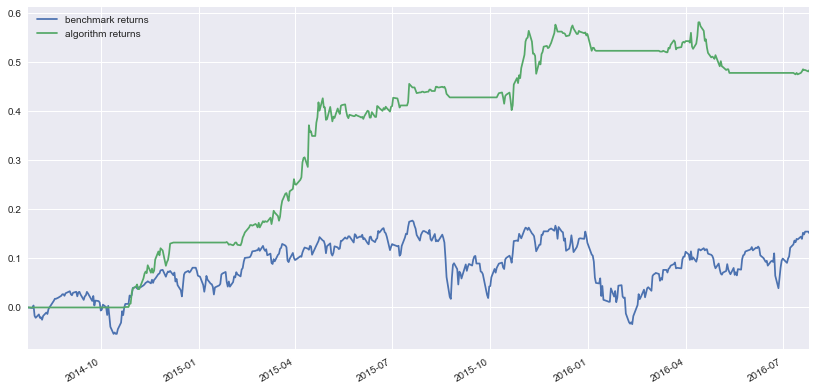

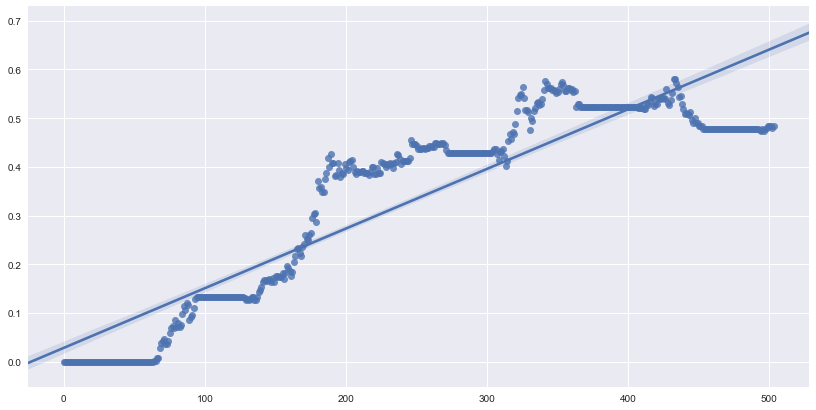

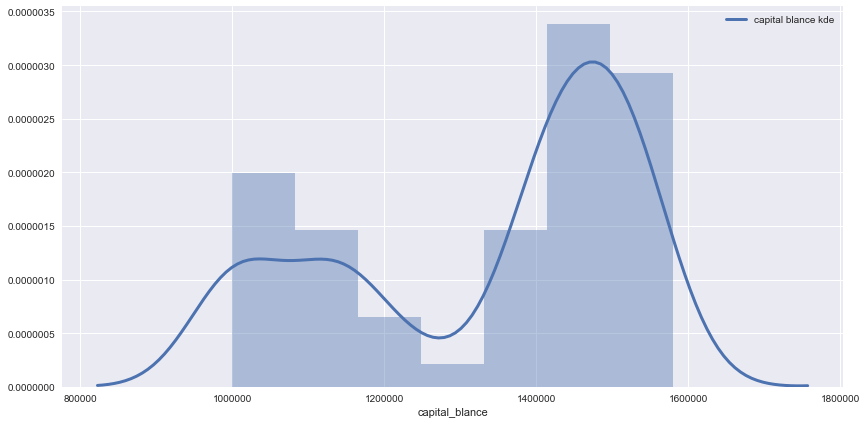

In [3]:
metrics = AbuMetricsBase(*abu_result_tuple)
metrics.fit_metrics()
metrics.plot_returns_cmp()

### 9.2 度量的基础

### 9.2.1 度量的基础概念

### 9.2.2 度量的可视化

alpha阿尔法:0.1979
beta贝塔:0.1476
Information信息比率:0.0445
策略Sharpe夏普比率: 1.9564
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.1076
基准波动率Volatility: 0.1689


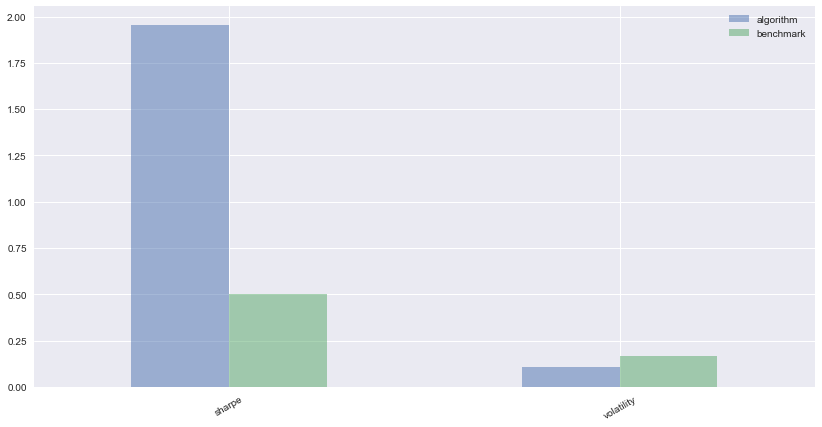

In [4]:
metrics.plot_sharp_volatility_cmp()

In [5]:
def sharpe(rets, ann=252):
    return rets.mean() / rets.std() * np.sqrt(ann)

print('策略sharpe值计算为＝{}'.format(sharpe(metrics.algorithm_returns)))

策略sharpe值计算为＝1.95641533363241


因子平均生效间隔:16.710526315789473


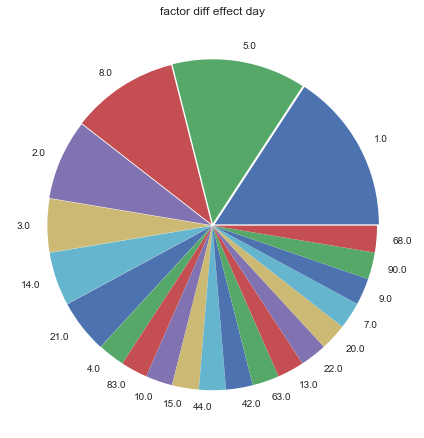

In [6]:
metrics.plot_effect_mean_day()

策略持股天数平均数: 40.857142857142854
策略持股天数中位数: 28.5


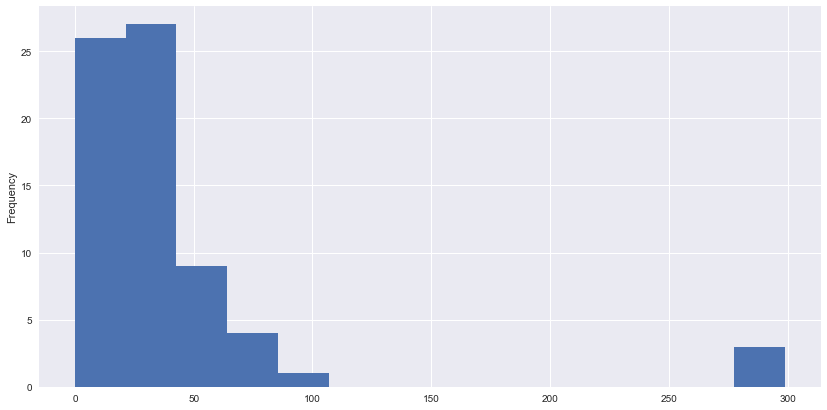

In [7]:
metrics.plot_keep_days()

卖出生效因子分布：
AbuFactorAtrNStop:stop_loss=1.0           18
AbuFactorAtrNStop:stop_win=3.0             9
AbuFactorCloseAtrNStop:close_atr_n=1.5    31
AbuFactorPreAtrNStop:pre_atr=1.5           9
dtype: int64


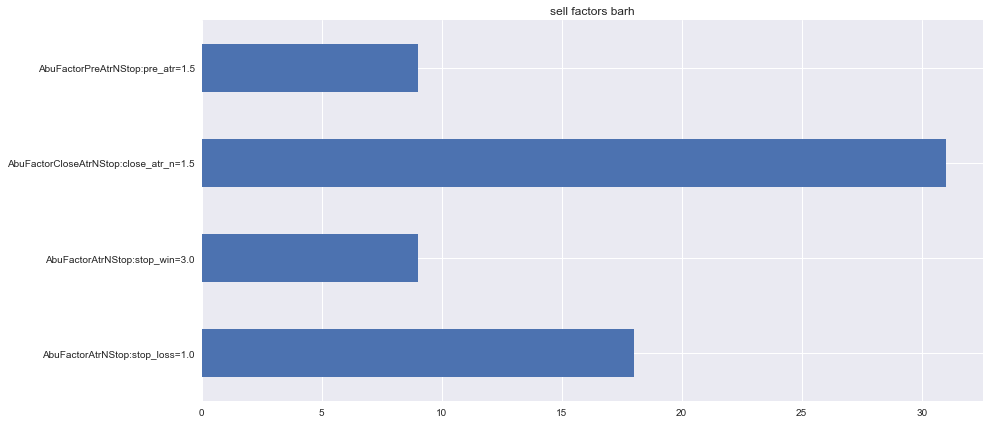

In [8]:
metrics.plot_sell_factors()

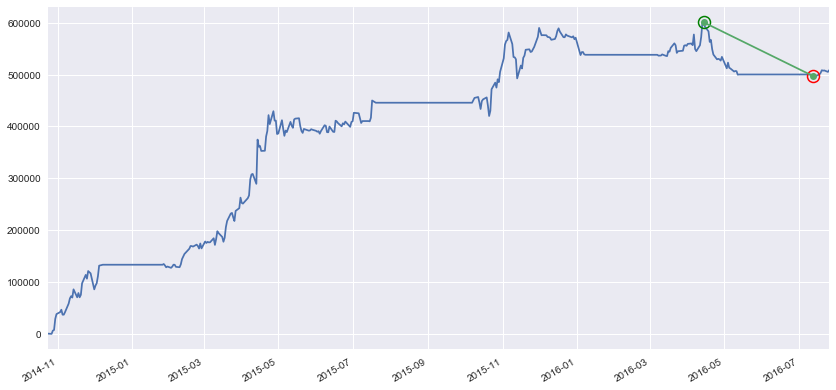

最大回撤: 0.06483096191700943
{(Timestamp('2016-04-14 00:00:00'), Timestamp('2016-07-13 00:00:00')): 103775.6649999998}


In [4]:
metrics.plot_max_draw_down()

## 9.3 基于grid search寻找因子最优参数

### 9.3.1 参数取值范围

In [4]:
stop_win_range = np.arange(2.0, 4.5, 0.5)
stop_loss_range = np.arange(0.5, 2, 0.5)

sell_atr_nstop_factor_grid = {
              'class': [AbuFactorAtrNStop],
              'stop_loss_n'   : stop_loss_range,
              'stop_win_n'   : stop_win_range
         }

print('止盈参数stop_win_n设置范围:{}'.format(stop_win_range))
print('止损参数stop_loss_n设置范围:{}'.format(stop_loss_range))

止盈参数stop_win_n设置范围:[ 2.   2.5  3.   3.5  4. ]
止损参数stop_loss_n设置范围:[ 0.5  1.   1.5]


In [5]:
close_atr_range = np.arange(1.0, 4.0, 0.5)
pre_atr_range = np.arange(1.0, 3.5, 0.5)

sell_atr_pre_factor_grid = {
              'class': [AbuFactorPreAtrNStop],
              'pre_atr_n' : pre_atr_range
         }

sell_atr_close_factor_grid = {
              'class': [AbuFactorCloseAtrNStop],
              'close_atr_n' : close_atr_range
         }

print('暴跌保护止损参数pre_atr_n设置范围:{}'.format(pre_atr_range))
print('盈利保护止盈参数close_atr_n设置范围:{}'.format(close_atr_range))

暴跌保护止损参数pre_atr_n设置范围:[ 1.   1.5  2.   2.5  3. ]
盈利保护止盈参数close_atr_n设置范围:[ 1.   1.5  2.   2.5  3.   3.5]


### 9.3.2 参数进行排列组合

In [6]:
sell_factors_product = ABuGridHelper.gen_factor_grid(
    ABuGridHelper.K_GEN_FACTOR_PARAMS_SELL,
    [sell_atr_nstop_factor_grid, sell_atr_pre_factor_grid, sell_atr_close_factor_grid])

print('卖出因子参数共有{}种组合方式'.format(len(sell_factors_product)))
print('卖出因子组合0形式为{}'.format(sell_factors_product[0]))

卖出因子参数共有477种组合方式
卖出因子组合0形式为[{'stop_loss_n': 0.5, 'class': <class 'abupy.FactorSellBu.ABuFactorAtrNStop.AbuFactorAtrNStop'>, 'stop_win_n': 2.0}, {'class': <class 'abupy.FactorSellBu.ABuFactorPreAtrNStop.AbuFactorPreAtrNStop'>, 'pre_atr_n': 1.0}, {'close_atr_n': 1.0, 'class': <class 'abupy.FactorSellBu.ABuFactorCloseAtrNStop.AbuFactorCloseAtrNStop'>}]


In [7]:
buy_bk_factor_grid1 = {
    'class': [AbuFactorBuyBreak],
    'xd': [42]
}

buy_bk_factor_grid2 = {
    'class': [AbuFactorBuyBreak],
    'xd': [60]
}

buy_factors_product = ABuGridHelper.gen_factor_grid(
    ABuGridHelper.K_GEN_FACTOR_PARAMS_BUY, [buy_bk_factor_grid1, buy_bk_factor_grid2])

print('买入因子参数共有{}种组合方式'.format(len(buy_factors_product)))
print('买入因子组合形式为{}'.format(buy_factors_product))

买入因子参数共有3种组合方式
买入因子组合形式为[[{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 42}, {'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}], [{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 42}], [{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}]]


### 9.3.3 GridSearch寻找最优参数

In [8]:
read_cash = 1000000
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG',
                  'usTSLA', 'usWUBA', 'usVIPS']
grid_search = GridSearch(read_cash, choice_symbols,
                         buy_factors_product=buy_factors_product,
                         sell_factors_product=sell_factors_product)

下面开始通过fit函数开始寻找最优，第一次运行select：run gird search，然后点击run select，如果已经运行过可select：load score cache直接从缓存数据读取

备注：如果第一次运行选择run gird search下面的运行耗时大约1小时多，建议电脑空闲时运行

In [9]:
scores = None
score_tuple_array = None

def run_grid_search():
    global scores, score_tuple_array
    # 运行GridSearch n_jobs=-1启动cpu个数的进程数
    scores, score_tuple_array = grid_search.fit(n_jobs=-1)
    # 运行完成输出的score_tuple_array可以使用dump_pickle保存在本地，以方便之后使用
    ABuFileUtil.dump_pickle(score_tuple_array, '../gen/score_tuple_array')

def load_score_cache():
    """有本地数据score_tuple_array后，即可以从本地缓存读取score_tuple_array"""
    global scores, score_tuple_array
    
    with AbuBlockProgress('load score cache'):
        score_tuple_array = ABuFileUtil.load_pickle('../gen/score_tuple_array')
        if not hasattr(grid_search, 'best_score_tuple_grid'):
            # load_pickle的grid_search没有赋予best_score_tuple_grid，这里补上
            from abupy import make_scorer, WrsmScorer
            scores = make_scorer(score_tuple_array, WrsmScorer)
            grid_search.best_score_tuple_grid = score_tuple_array[scores.index[-1]]
        
def select(select):
    if select == 'run gird search':
        run_grid_search()
    else: # load score cache
        load_score_cache()

_ = ipywidgets.interact_manual(select, select=['run gird search', 'load score cache'])

In [10]:
print('组合因子参数数量{}'.format(len(buy_factors_product) * len(sell_factors_product) ))
# 如果从本地序列文件中读取则没有scores
print('最终评分结果数量{}'.format(len(scores)))

组合因子参数数量1431
最终评分结果数量1431


买入后卖出的交易数量:38
买入后尚未卖出的交易数量:2
胜率:60.5263%
平均获利期望:13.4462%
平均亏损期望:-6.0647%
盈亏比:3.2382
策略收益: 31.5812%
基准收益: 15.0841%
策略年化收益: 15.7906%
基准年化收益: 7.5420%
策略买入成交比例:100.0000%
策略资金利用率比例:18.0478%
策略共执行504个交易日


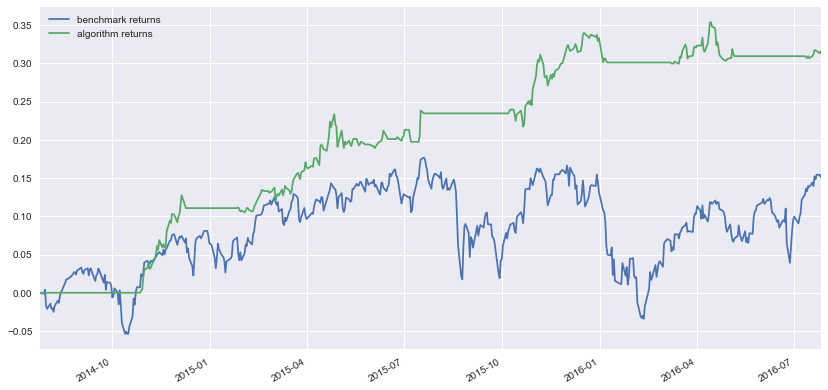

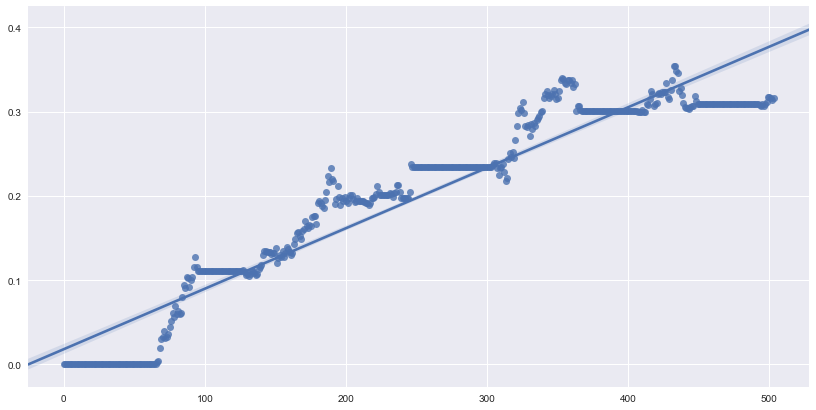

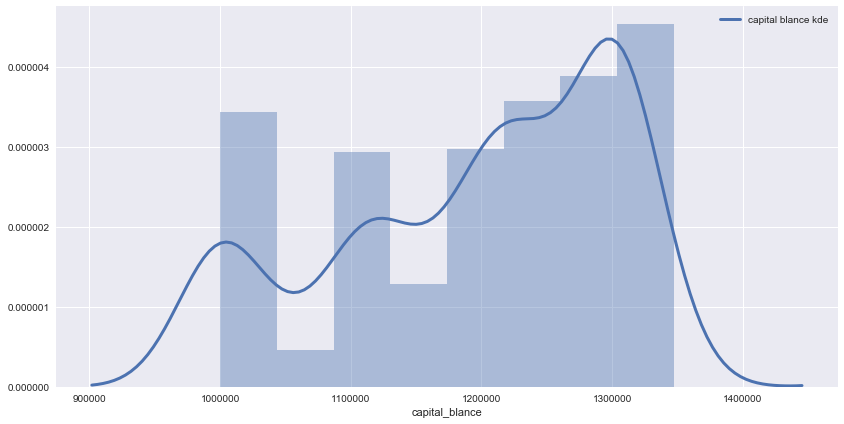

alpha阿尔法:0.1310
beta贝塔:0.1100
Information信息比率:0.0210
策略Sharpe夏普比率: 1.8907
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.0742
基准波动率Volatility: 0.1689


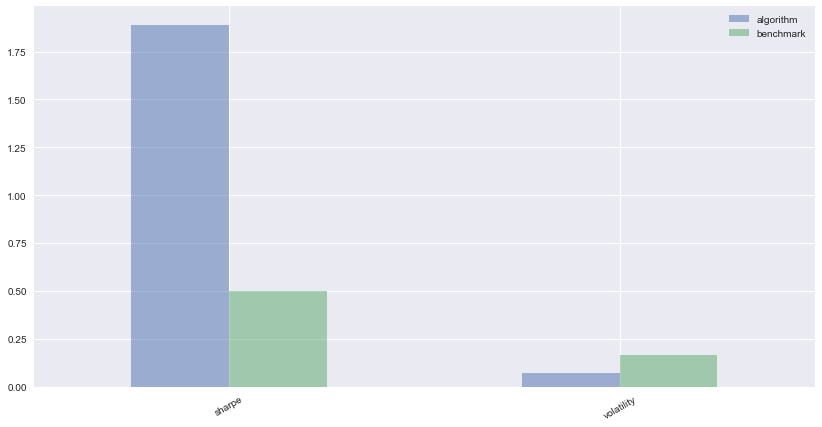

In [16]:
best_score_tuple_grid = grid_search.best_score_tuple_grid
AbuMetricsBase.show_general(best_score_tuple_grid.orders_pd, best_score_tuple_grid.action_pd,
                                        best_score_tuple_grid.capital, best_score_tuple_grid.benchmark)

### 9.3.4 度量结果的评分

In [20]:
from abupy import WrsmScorer
# 实例化一个评分类WrsmScorer，它的参数为之前GridSearch返回的score_tuple_array对象
scorer = WrsmScorer(score_tuple_array)

In [21]:
scorer.score_pd.tail()

,win_rate,returns,sharpe,max_drawdown,score_win_rate,score_returns,score_sharpe,score_max_drawdown,score
1426,0.8095,0.1415,0.4983,-0.2163,0.9965,0.6399,0.4063,0.0594,0.5255
1427,0.8095,0.1253,0.4516,-0.2137,0.9965,0.5790,0.3664,0.0650,0.5017
1428,0.7619,0.0142,0.1262,-0.2911,0.9944,0.1727,0.1769,0.0182,0.3406
1429,0.5714,-0.0169,0.0252,-0.2864,0.8965,0.0972,0.1189,0.0196,0.2830
1430,0.0000,-0.0821,-0.0282,-0.4167,0.0007,0.0322,0.0979,0.0014,0.0330


In [22]:
# score_tuple_array[658]与grid_search.best_score_tuple_grid是一致的
sfs = scorer.fit_score()
# 打印前15个高分组合
sfs[::-1][:15]

658    0.9740
664    0.9696
808    0.9678
688    0.9664
670    0.9608
838    0.9593
682    0.9577
676    0.9577
694    0.9549
657    0.9505
807    0.9460
754    0.9458
687    0.9455
724    0.9430
814    0.9404
Name: score, dtype: float64

### 9.3.5 不同权重的评分

In [23]:
# 实例化WrsmScorer，参数weights，只有第二项为1，其他都是0，
# 代表只考虑投资回报来评分
scorer = WrsmScorer(score_tuple_array, weights=[0, 1, 0, 0])
# 返回排序后的队列
scorer_returns_max = scorer.fit_score()
# 因为是倒序排序，所以index最后一个为最优参数
best_score_tuple_grid = score_tuple_array[scorer_returns_max.index[-1]]
# 由于篇幅，最优结果只打印文字信息
AbuMetricsBase.show_general(best_score_tuple_grid.orders_pd,
                            best_score_tuple_grid.action_pd,
                            best_score_tuple_grid.capital,
                            best_score_tuple_grid.benchmark,
                            only_info=True)

买入后卖出的交易数量:51
买入后尚未卖出的交易数量:19
胜率:82.3529%
平均获利期望:16.2075%
平均亏损期望:-7.6414%
盈亏比:8.8162
策略收益: 49.7671%
基准收益: 15.0841%
策略年化收益: 24.8835%
基准年化收益: 7.5420%
策略买入成交比例:62.8571%
策略资金利用率比例:41.3748%
策略共执行504个交易日
alpha阿尔法:0.1810
beta贝塔:0.3710
Information信息比率:0.0485
策略Sharpe夏普比率: 1.4955
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.1420
基准波动率Volatility: 0.1689


In [24]:
# 最后打印出只考虑投资回报下最优结果使用的买入策略和卖出策略
best_score_tuple_grid.buy_factors, best_score_tuple_grid.sell_factors

([{'class': abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak, 'xd': 42},
  {'class': abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak, 'xd': 60}],
 [{'class': abupy.FactorSellBu.ABuFactorCloseAtrNStop.AbuFactorCloseAtrNStop,
   'close_atr_n': 1.5}])

买入后卖出的交易数量:21
买入后尚未卖出的交易数量:9
胜率:85.7143%
平均获利期望:19.0903%
平均亏损期望:-9.2893%
盈亏比:9.4105
策略收益: 21.5035%
基准收益: 15.0841%
策略年化收益: 10.7518%
基准年化收益: 7.5420%
策略买入成交比例:86.6667%
策略资金利用率比例:44.3042%
策略共执行504个交易日


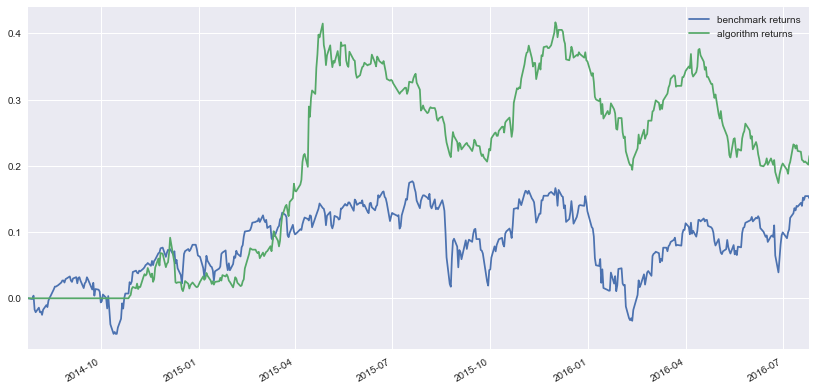

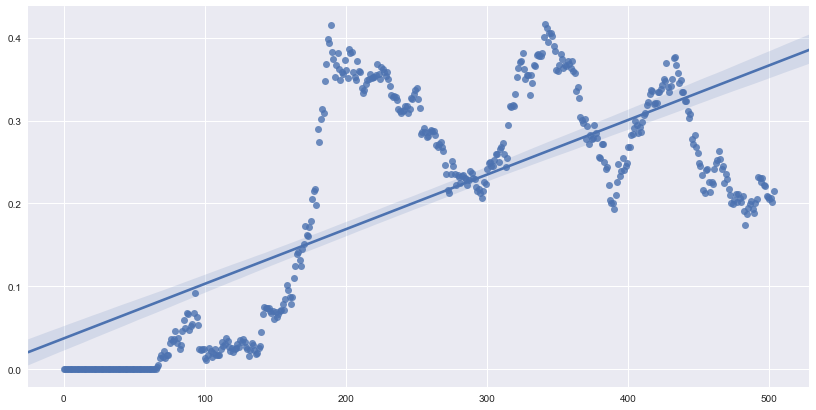

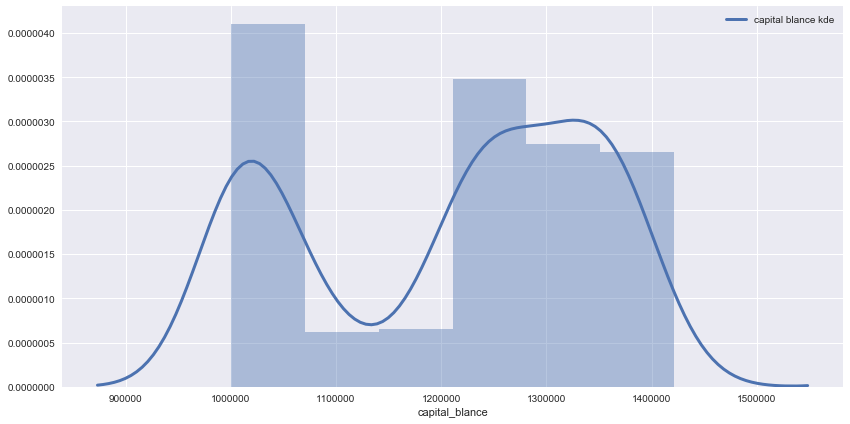

alpha阿尔法:0.0724
beta贝塔:0.4226
Information信息比率:0.0092
策略Sharpe夏普比率: 0.7392
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.1464
基准波动率Volatility: 0.1689


([{'class': abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak, 'xd': 60}],
 [{'class': abupy.FactorSellBu.ABuFactorCloseAtrNStop.AbuFactorCloseAtrNStop,
   'close_atr_n': 1.5}])

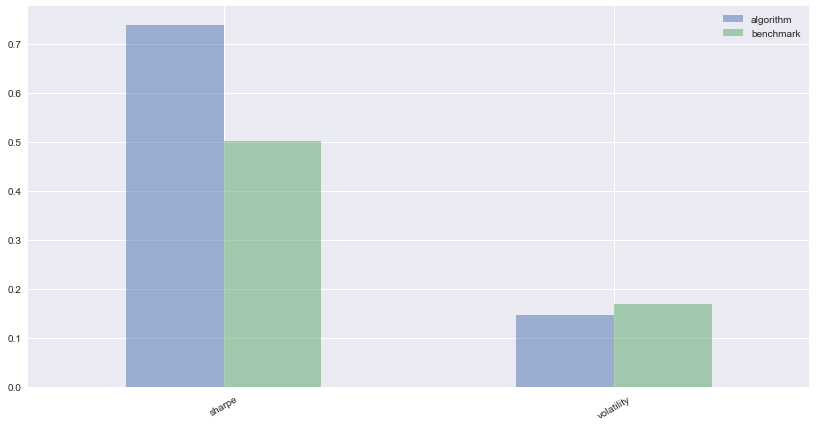

In [25]:
# 只有第一项为1，其他都是0代表只考虑胜率来评分
scorer = WrsmScorer(score_tuple_array, weights=[1, 0, 0, 0])
# 返回按照评分排序后的队列
scorer_returns_max = scorer.fit_score()
# index[-1]为最优参数序号
best_score_tuple_grid = score_tuple_array[scorer_returns_max.index[-1]]
AbuMetricsBase.show_general(best_score_tuple_grid.orders_pd,
                            best_score_tuple_grid.action_pd,
                            best_score_tuple_grid.capital,
                            best_score_tuple_grid.benchmark,
                            only_info=False)

# 最后打印出只考虑胜率下最优结果使用的买入策略和卖出策略
best_score_tuple_grid.buy_factors, best_score_tuple_grid.sell_factors


## 9.4 资金限制对度量的影响

关闭沙盒数据环境

如下内容即不能使用沙盒环境, 建议对照阅读*abu量化文档－第十九节* 以及之后的内容

In [3]:
abupy.env.disable_example_env_ipython()

from abupy import AbuMetricsBase, AbuFactorCloseAtrNStop, AbuFactorPreAtrNStop, AbuFactorAtrNStop, AbuFactorBuyBreak
from abupy import abu, EMarketDataFetchMode, EMarketTargetType, EStoreAbu, EMarketSourceType, EDataCacheType, ABuProgress
import ipywidgets

disable example env


所有获取的数据已经存放在百度云盘上，后面的章节使用的数据都是本节更新的数据，建议直接从云盘下载入库完毕的数据库，不需要从各个数据源再一个一个的下载数据进行入库，百度云地址如下：

[csv格式美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1geNZgqf) 密码: gvtr

下面数据存贮格式为hdf5数据，由于hdf5文件解压后非常大，还需要区分python版本，所以如果没有足够的存贮空间
特别是python2下，建议使用csv格式的缓存文件：

[mac系统python3 美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1o8sldNk) 密码: ecyp

[mac系统python2 A股6年日k数据: ](https://pan.baidu.com/s/1bptn25h) 密码: sid8

[mac系统python2 美股6年日k数据: ](https://pan.baidu.com/s/1geHR9Lp) 密码: uaww

[windows python3 美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1bzeVHO) 密码: 3cwe

[windows python2 A股6年日k数据: ](https://pan.baidu.com/s/1skZOe7N) 密码: 78mb

[windows python2 美股6年日k数据: ](https://pan.baidu.com/s/1i5MNzKx) 密码: 63r3

下载完毕上述数据后，hdf5解压得到df_kl.h5文件，csv解压得到csv文件夹，解压后放到下面路径下即可

In [ ]:
if abupy.env.g_is_mac_os:
    !open $abupy.env.g_project_data_dir
else:
    !echo $abupy.env.g_project_data_dir

如果不想通过直接下载数据文件的方式，也可下面通过切换至腾讯数据源，然后进行美股数据全市场更新：

备注：耗时操作，大概需要运行15分钟左右，可以在做其它事情的时候运行

In [4]:
def tx_us():
    abupy.env.g_market_source = EMarketSourceType.E_MARKET_SOURCE_tx
    abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_CSV
    abu.run_kl_update(start='2011-08-08', end='2017-08-08', market=EMarketTargetType.E_MARKET_TARGET_US, n_jobs=10)

# 避免使用notebook运行run all时运行不想执行的代码
_ = ipywidgets.interact_manual(tx_us)

买入因子，卖出因子等依然使用相同的设置，如下所示：

In [5]:
# 初始化资金500万
read_cash = 5000000

# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

将数据读取模式设置为本地数据模式，即进行全市场回测时最合适的模式，运行效率高，且分类数据更新和交易回测。

In [6]:
abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL

下面将回测市场设置为美股市场：

In [7]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US

下面通过env中的设置将回测中的symbols切分为回测训练集与回测测试集，且打开回测生成买入时刻特征开关：

In [8]:
# 回测时生成买入时刻特征
abupy.env.g_enable_ml_feature = True
# 回测时将symbols切割分为训练集数据和测试集两份，使用训练集进行回测
abupy.env.g_enable_train_test_split = True

下面设置回测时切割训练集，测试集使用的切割比例参数，默认为10，即切割为10份，9份做为训练，1份做为测试，由于美股股票数量多，所以切割分为4份，3份做为训练集，1份做为测试集：

In [9]:
abupy.env.g_split_tt_n_folds = 4

资金管理依然使用默认atr，每笔交易的买入基数资金设置为万分之20，这个值如果设置太大，比如初始默认的0.1的话，将会导致太多的股票由于资金不足无法买入，丧失全市场回测的意义，如果太小的话又会导致资金利用率下降，导致最终收益下降：

更多资金管理请阅读相关源代码或《量化交易之路》中相关内容

In [10]:
# 每笔交易的买入基数资金设置为万分之15
abupy.beta.atr.g_atr_pos_base = 0.0015

在上面run_kl_update中更新了从2011-08-08至2017-08-08，由于在买入时刻生成特征，所以要保留一年的数据做为特征数据回测时段，所以下面的回测start使用2012-08-08至2017-08-08，即向后推了一年做回测：

下面开始回测，第一次运行select：run loop back，然后点击run select，如果已经回测过可select：load train data直接从缓存数据读取：

In [11]:
abu_result_tuple = None
def run_loop_back():
    global abu_result_tuple
    abu_result_tuple, _ = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   choice_symbols=None,
                                                   start='2012-08-08', end='2017-08-08', n_process_pick=5)
    # 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
    abu.store_abu_result_tuple(abu_result_tuple, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='train_us')
    ABuProgress.clear_output()

def run_load_train():
    global abu_result_tuple
    abu_result_tuple = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                                 custom_name='train_us')

def select(select):
    if select == 'run loop back':
        run_loop_back()
    else:
        run_load_train()

_ = ipywidgets.interact_manual(select, select=['run loop back', 'load train data'])

please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_train_us_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_train_us_benchmark


下面从回测结果action_pd.deal中可以看到由于很多时候资金不足，导致大约只有1/3的单子成交：

In [12]:
abu_result_tuple.action_pd.deal.value_counts()

False    122574
True      58274
Name: deal, dtype: int64

使用AbuMetricsBase度量结果，从metrics.plot_returns_cmp()函数度量输出中显示，策略买入成交比例为31.7084%：

买入后卖出的交易数量:89418
买入后尚未卖出的交易数量:2012
胜率:46.5220%
平均获利期望:8.4475%
平均亏损期望:-5.6229%
盈亏比:1.3312
策略收益: 61.3978%
基准收益: 111.5646%
策略年化收益: 12.2991%
基准年化收益: 22.3484%
策略买入成交比例:31.7084%
策略资金利用率比例:88.6240%
策略共执行1258个交易日


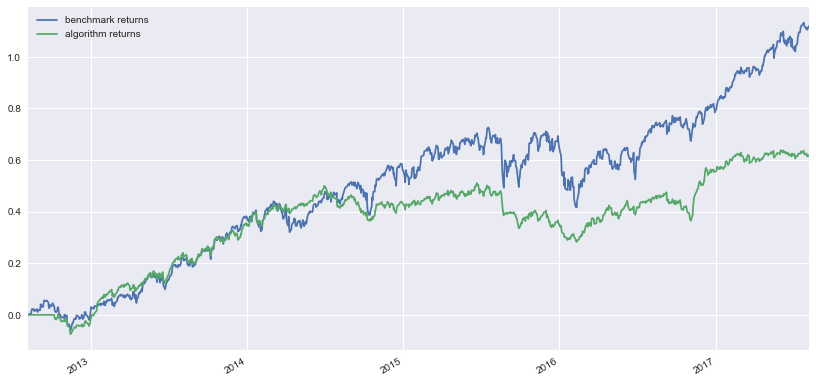

In [13]:
metrics_train = AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

下面通过env中设置使用刚才切分的测试集美股symbol，它使用pickle读取之前已经切割好的本地化测试集股票代码序列：

In [14]:
# 回测时使用切割好的测试数据
abupy.env.g_enable_last_split_test = True

提高g_atr_pos_base为0.007（因为默认切割训练集与测试集数据比例为4:1，所以提高g_atr_pos_base为之前的大概3-5倍都可以：

In [15]:
abupy.beta.atr.g_atr_pos_base = 0.007

下面开始回测，第一次运行select：run loop back，然后点击run select_test，如果已经回测过可select：load test data直接从缓存数据读取：

In [16]:
abu_result_tuple_test = None
def run_loop_back_test():
    global abu_result_tuple_test
    abu_result_tuple_test, _ = abu.run_loop_back(read_cash,
                                                 buy_factors,
                                                 sell_factors,
                                                 choice_symbols=None,
                                                 start='2012-08-08', end='2017-08-08')
    # 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
    abu.store_abu_result_tuple(abu_result_tuple_test, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='test_us')
    ABuProgress.clear_output()

def run_load_test():
    global abu_result_tuple_test
    abu_result_tuple_test = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                                 custom_name='test_us')

def select_test(select):
    if select == 'run loop back':
        run_loop_back_test()
    else:
        run_load_test()

_ = ipywidgets.interact_manual(select_test, select=['run loop back', 'load test data'])

please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_us_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_us_benchmark


使用AbuMetricsBase度量结果, 测试集策略买入成交比例为20.8674%：

买入后卖出的交易数量:29786
买入后尚未卖出的交易数量:625
胜率:46.5420%
平均获利期望:8.4243%
平均亏损期望:-5.7298%
盈亏比:1.3117
策略收益: 63.2158%
基准收益: 111.5646%
策略年化收益: 12.6633%
基准年化收益: 22.3484%
策略买入成交比例:20.8674%
策略资金利用率比例:90.2922%
策略共执行1258个交易日


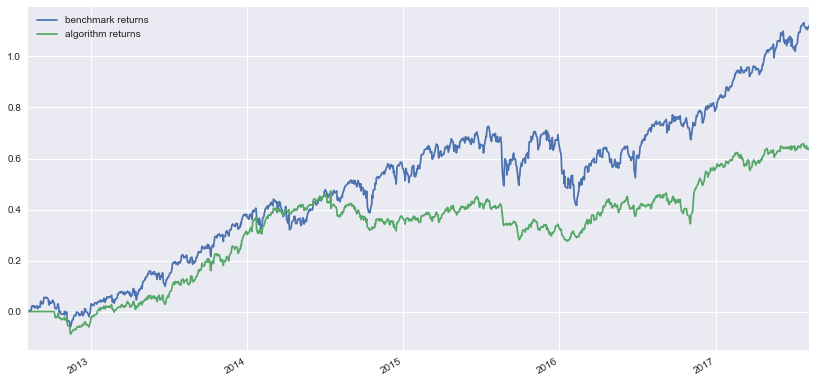

In [17]:
metrics_test = AbuMetricsBase.show_general(*abu_result_tuple_test, only_show_returns=True)

## 满仓乘数

《量化交易之路》中通过把初始资金扩大到非常大，但是每笔交易的买入基数却不增高，来使交易全部都成交，再使用满仓乘数的示例，由于需要再次进行全市场回测，比较耗时，下面直接示例通过AbuMetricsBase中的transform_to_full_rate_factor接口将之前的回测结果转换为使用大初始资金回测的结果：


第一次运行select：transform，然后点击run select_full，如果已经运行过可select：load直接从缓存数据读取：

备注：即使不重新做全市场回测，由于设计所有交易单的重新计算，所有仍然需要时间，下面操作属于耗时操作

In [29]:
test_frm = None
def run_transform():
    global test_frm
    test_frm = metrics_test.transform_to_full_rate_factor(n_process_kl=4, show=False)
    
    # 转换后保存起来，下次直接读取，不用再转换了
    from abupy import AbuResultTuple
    test_us_fr = AbuResultTuple(test_frm.orders_pd, test_frm.action_pd, test_frm.capital, test_frm.benchmark)
    abu.store_abu_result_tuple(test_us_fr, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='test_us_full_rate')

def run_load():
    global test_frm
    test_us_fr = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                           custom_name='test_us_full_rate')
    # 本地读取后使用AbuMetricsBase构造度量对象，参数enable_stocks_full_rate_factor=True, 即使用满仓乘数
    test_frm = AbuMetricsBase(test_us_fr.orders_pd, test_us_fr.action_pd, test_us_fr.capital, test_us_fr.benchmark,
                              enable_stocks_full_rate_factor=True)
    test_frm.fit_metrics()

def select_full(select):
    if select == 'transform':
        run_transform()
    else:
        run_load()

_ = ipywidgets.interact_manual(select_full, select=['transform', 'load'])

please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_us_full_rate_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_us_full_rate_benchmark


使用test_frm进行度量结果可以看到所有交易都顺利成交了，策略买入成交比例:100.0000%，但资金利用率显然过低，它导致基准收益曲线和策略收益曲线不在一个量级上，无法有效的进行对比：

买入后卖出的交易数量:29786
买入后尚未卖出的交易数量:625
胜率:46.5420%
平均获利期望:8.4243%
平均亏损期望:-5.7298%
盈亏比:1.3117
策略收益: 12.2341%
基准收益: 111.5646%
策略年化收益: 2.4507%
基准年化收益: 22.3484%
策略买入成交比例:100.0000%
策略资金利用率比例:29.7226%
策略共执行1258个交易日


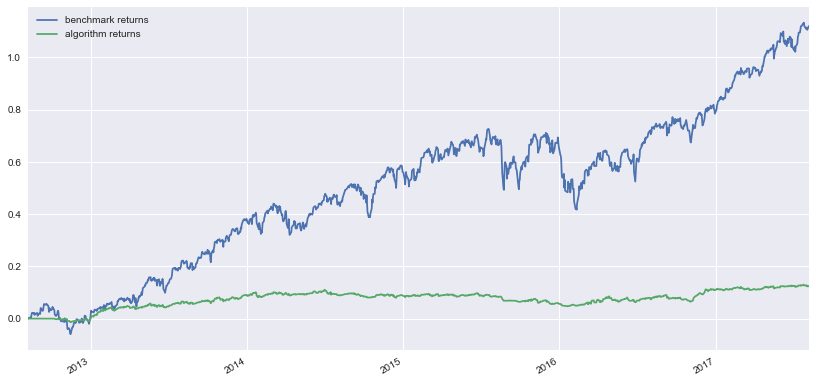

In [30]:
AbuMetricsBase.show_general(test_frm.orders_pd, 
                            test_frm.action_pd, test_frm.capital, test_frm.benchmark, only_show_returns=True)

转换出来的test_frm即是一个使用满仓乘数的度量对象，下面使用test_frm直接进行满仓度量即可：

买入后卖出的交易数量:29786
买入后尚未卖出的交易数量:625
胜率:46.5420%
平均获利期望:8.4243%
平均亏损期望:-5.7298%
盈亏比:1.3117
策略收益: 61.8465%
基准收益: 111.5646%
策略年化收益: 12.3890%
基准年化收益: 22.3484%
策略买入成交比例:100.0000%
策略资金利用率比例:29.7226%
策略共执行1258个交易日


<class 'abupy.MetricsBu.ABuMetricsBase.AbuMetricsBase'>


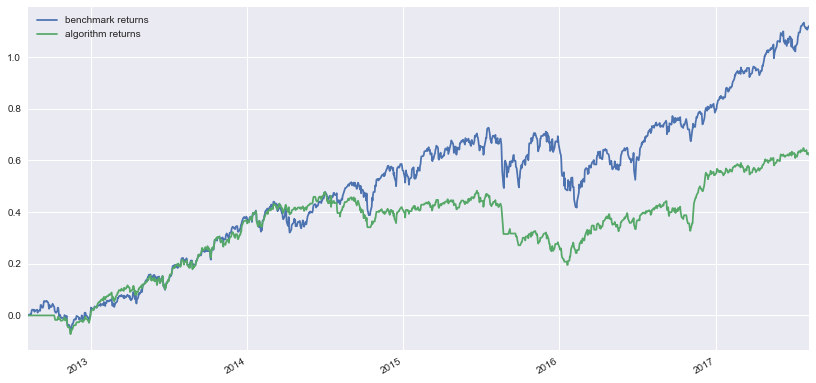

In [31]:
print(type(test_frm))
test_frm.plot_returns_cmp(only_show_returns=True)

如果不需要与基准进行对比，最简单的方式是使用plot_order_returns_cmp()函数，之后章节‘第11章-量化系统-机器学习•ABU’会使用plot_order_returns_cmp()度量对比开启裁判系统和未开启裁判系统的交易结果：

In [22]:
# 如果不需要与基准进行对比，最简单的方式是使用plot_order_returns_cmp
metrics_test.plot_order_returns_cmp()

买入后卖出的交易数量:29786
买入后尚未卖出的交易数量:625
胜率:46.5420%
平均获利期望:8.4243%
平均亏损期望:-5.7298%
盈亏比:1.3117
所有交易收益比例和:260.3562 
所有交易总盈亏和:14980168.6900 


_____

## 其它市场的回测

### A股市场训练集交易回测

**请阅读abu量化文档相关章节**